In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import torch
import random
import csv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import AUROC, Accuracy, ConfusionMatrix, F1Score
import os, subprocess, gc, time, datetime
from itertools import product

import models.models_original as models_original
import models.models_3d_atomics as models_3d_atomics
import models.models_3d as models_3d
from models.data import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import *

device = get_free_gpu()

current device cuda:2


In [2]:
train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(output_dim = 2, batch_size = 512, random_state = 1)

print(class_weights, num_classes, seq_len)

for batch in train_loader:
    [print(t.shape, t.device) for t in batch]
    break

len(train_loader)

tensor([0.5797, 3.6376], dtype=torch.float64) 2 6
torch.Size([512, 6, 27]) cpu
torch.Size([512, 6, 27]) cpu
torch.Size([512, 8]) cpu
torch.Size([512, 2]) cpu


35

In [3]:
auroc_metric = AUROC(task="binary").to(device)
accuracy_metric = Accuracy(task="binary").to(device)
f1_metric = F1Score(task="binary").to(device)
conf_matrix = ConfusionMatrix(task="binary").to(device)

In [4]:
print(changing_dim, static_dim, seq_len)

random_seed = 1
set_seed(random_seed)

experiment_folder = "/workdir/optimal-summaries-public/_models/vasopressor/shared/"
top_k_file = experiment_folder + "top-k/bottleneck_topkinds_seed_{seed}.csv"
makedir(top_k_file)

random_seeds = range(1,4)


27 8 6


## Optimization

In [5]:
def get_model(random_seed):
    set_seed(random_seed)

    config = {
        "n_concepts": 4,
        "encode_time_dim": True,
    }
    
    makedir(experiment_folder)
    model_path = get_filename_from_dict(experiment_folder, config)

    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)

    model = models_3d.CBM(**config, static_dim=static_dim, changing_dim=changing_dim, seq_len=seq_len, output_dim=2, top_k=None, device=device)
    model.try_load_else_fit(train_loader, val_loader, p_weight=class_weights, save_model_path=model_path.format(**config, seed = random_seed), max_epochs=10000)

    evaluate_classification(model, test_loader)
    return model

model = get_model(1)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.918
ACC macro 0.845
 F1 macro 0.853


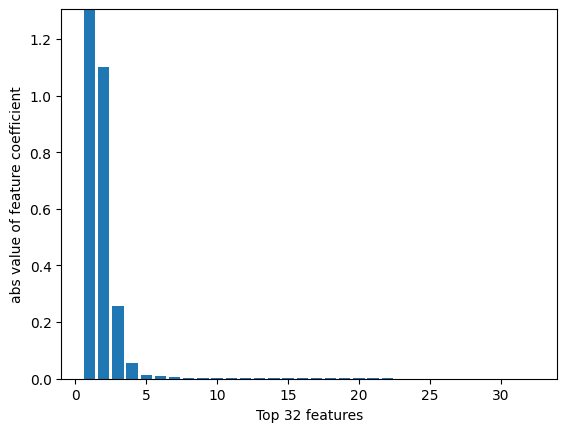

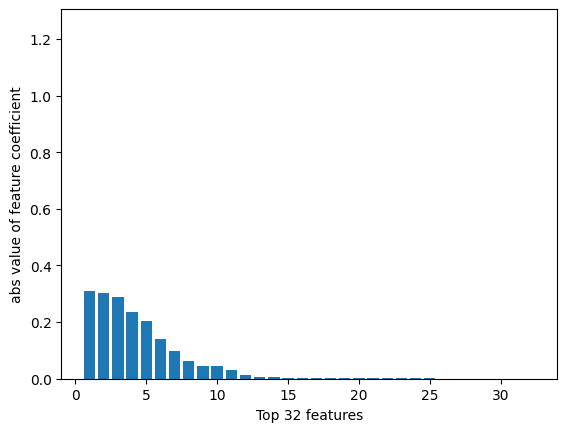

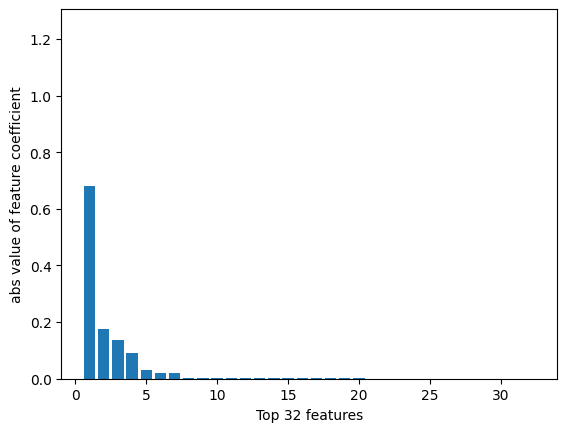

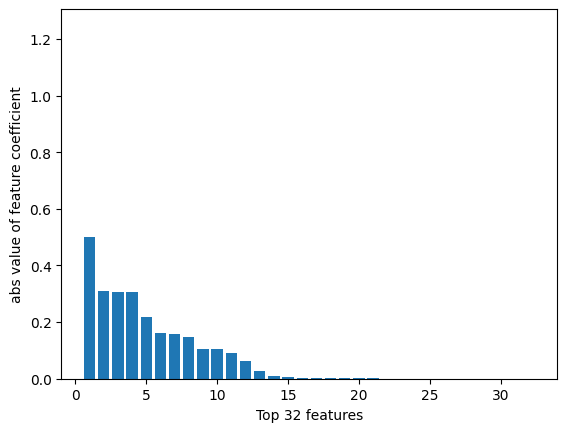

In [6]:
visualize_top100_weights_per_channel(model.bottleneck)


In [6]:
track_metrics={"acc": accuracy_metric,
               "f1": f1_metric,
               "auc": auroc_metric,
               }

results = []
for random_seed in random_seeds:
    print("random_seed", random_seed)
    model = get_model(random_seed)
    train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)
    top_k_inds = [get_top_features_per_concept(layer) for layer in model.regularized_layers]
    save_path = top_k_file.format(seed=random_seed)
    
    greedy_results = greedy_forward_selection(model=model, layers_to_prune=model.regularized_layers, top_k_inds=top_k_inds, val_loader=val_loader, optimize_metric=auroc_metric, track_metrics=track_metrics, save_path=save_path)
    results.append(greedy_results)
    

random_seed 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.918
ACC macro 0.845
 F1 macro 0.853
Found 4 Concepts
90th percentile per concept [2.5083573 1.6249595 1.0640838 2.2702925]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']
Successfully loaded greedy search results!
random_seed 2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.916
ACC macro 0.841
 F1 macro 0.849
Found 4 Concepts
90th percentile per concept [2.8524153 1.0739814 1.6037425 1.8704009]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']
Successfully loaded greedy search results!
random_seed 3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.915
ACC macro 0.840
 F1 macro 0.848
Found 4 Concepts
90th percentile per concept [1.4761708 1.0564556 3.3771372 1.8016205]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']
Successfully loaded greedy search results!


In [7]:
random_seed = 1
model = get_model(random_seed)
top_k_inds = get_top_features_per_concept(model.bottleneck)
greedy_results = read_df_from_csv(top_k_file.format(seed=random_seed))

pd.set_option('display.max_rows', 100)

print(len(top_k_inds))
[print(x) for x in top_k_inds]
greedy_results


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.918
ACC macro 0.845
 F1 macro 0.853
Found 4 Concepts
90th percentile per concept [2.5083573 1.6249595 1.0640838 2.2702925]
['Concept 0 len: 10', 'Concept 1 len: 10', 'Concept 2 len: 10', 'Concept 3 len: 10']
4
[31, 30, 5, 3, 0, 21, 17, 4, 25, 19]
[8, 11, 10, 21, 9, 6, 27, 2, 24, 17]
[24, 18, 21, 5, 13, 12, 31, 2, 3, 14]
[21, 16, 0, 17, 8, 12, 1, 6, 24, 14]


,Score,Layer,Concept,Feature,acc,f1,auc
0,0.906757,0,1,27,0.594973,0.708922,0.906757
1,0.913974,0,0,3,0.652539,0.737660,0.913974
2,0.915380,0,2,12,0.665837,0.745541,0.915380
3,0.915505,0,2,3,0.665752,0.745493,0.915505
4,0.915584,0,2,2,0.666095,0.745721,0.915584
5,0.915597,0,0,25,0.665494,0.745413,0.915597
6,0.915571,0,0,19,0.665666,0.745377,0.915571
7,0.915528,0,0,4,0.667982,0.746562,0.915528
8,0.915480,0,2,31,0.695693,0.761834,0.915480
9,0.915295,0,2,14,0.695779,0.762013,0.915295


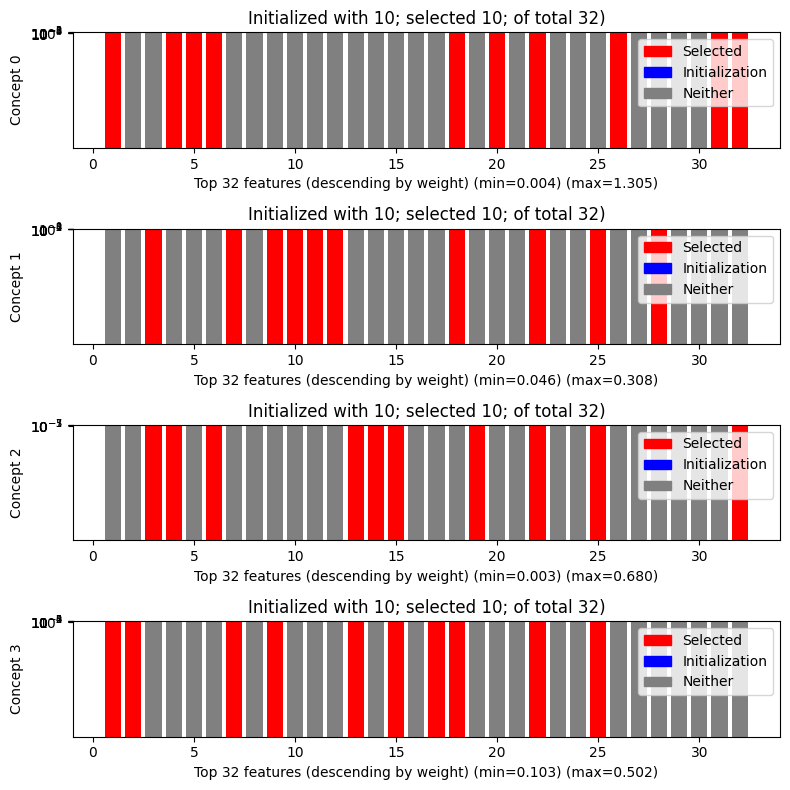

In [11]:
plot_selected_weights(model.bottleneck.weight, top_k_inds, greedy_results, top_k=100, sorted=False, log_scale=True)

In [19]:
result_df = evaluate_greedy_selection(get_model, get_MIMIC_dataloader, top_k_file, n_experiments=3)
result_df.groupby(["Split", "Mask", "Finetuned"]).mean()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_1.pt
AUC macro 0.918
ACC macro 0.845
 F1 macro 0.853
AUC macro 0.915
ACC macro 0.840
 F1 macro 0.847
AUC macro 0.918
ACC macro 0.845
 F1 macro 0.853
AUC macro 0.914
ACC macro 0.840
 F1 macro 0.847
AUC macro 0.918
ACC macro 0.843
 F1 macro 0.851


  3%|▎         | 260/10000 [04:08<2:35:08,  1.05 epoch/s, Train Loss=0.47437, Val Loss=0.51658, Best Val Loss=0.51420]

Early Stopped


AUC macro 0.916
ACC macro 0.844
 F1 macro 0.851
AUC macro 0.920
ACC macro 0.848
 F1 macro 0.855


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.916
ACC macro 0.841
 F1 macro 0.849
AUC macro 0.920
ACC macro 0.845
 F1 macro 0.852
AUC macro 0.916
ACC macro 0.841
 F1 macro 0.849
AUC macro 0.919
ACC macro 0.846
 F1 macro 0.853
AUC macro 0.916
ACC macro 0.839
 F1 macro 0.847
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/finetuned/n_concepts_4_encode_time_dim_True_seed_2.pt
AUC macro 0.919
ACC macro 0.844
 F1 macro 0.852
AUC macro 0.916
ACC macro 0.838
 F1 macro 0.846


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.915
ACC macro 0.840
 F1 macro 0.848
AUC macro 0.923
ACC macro 0.849
 F1 macro 0.856
AUC macro 0.915
ACC macro 0.840
 F1 macro 0.848
AUC macro 0.924
ACC macro 0.850
 F1 macro 0.857
AUC macro 0.916
ACC macro 0.843
 F1 macro 0.851
Loaded model from /workdir/optimal-summaries-public/_models/vasopressor/shared/finetuned/n_concepts_4_encode_time_dim_True_seed_3.pt
AUC macro 0.922
ACC macro 0.846
 F1 macro 0.854
AUC macro 0.914
ACC macro 0.837
 F1 macro 0.846


Seed       AUC       ACC        F1
Split Mask   Finetuned                                    
test  Empty  False       2.0  0.916582  0.842114  0.850010
      Greedy False       2.0  0.916601  0.841714  0.849471
             True        2.0  0.916506  0.841027  0.848892
val   Empty  False       2.0  0.919516  0.844458  0.851743
      Greedy False       2.0  0.919071  0.845058  0.852317
             True        2.0  0.918985  0.844887  0.852132

In [ ]:
model = get_model(random_seed)
greedy_results = read_df_from_csv(top_k_file.format(seed=random_seed))

train_loader, val_loader, test_loader, class_weights, num_classes, changing_dim, static_dim, seq_len = get_MIMIC_dataloader(random_state = random_seed)

visualize_optimization_results(model, val_loader, test_loader, greedy_results)
